Loading ptbxl_database.csv to map filename_hr to ecg_id...

Processing subset of 8 records for phase folding...


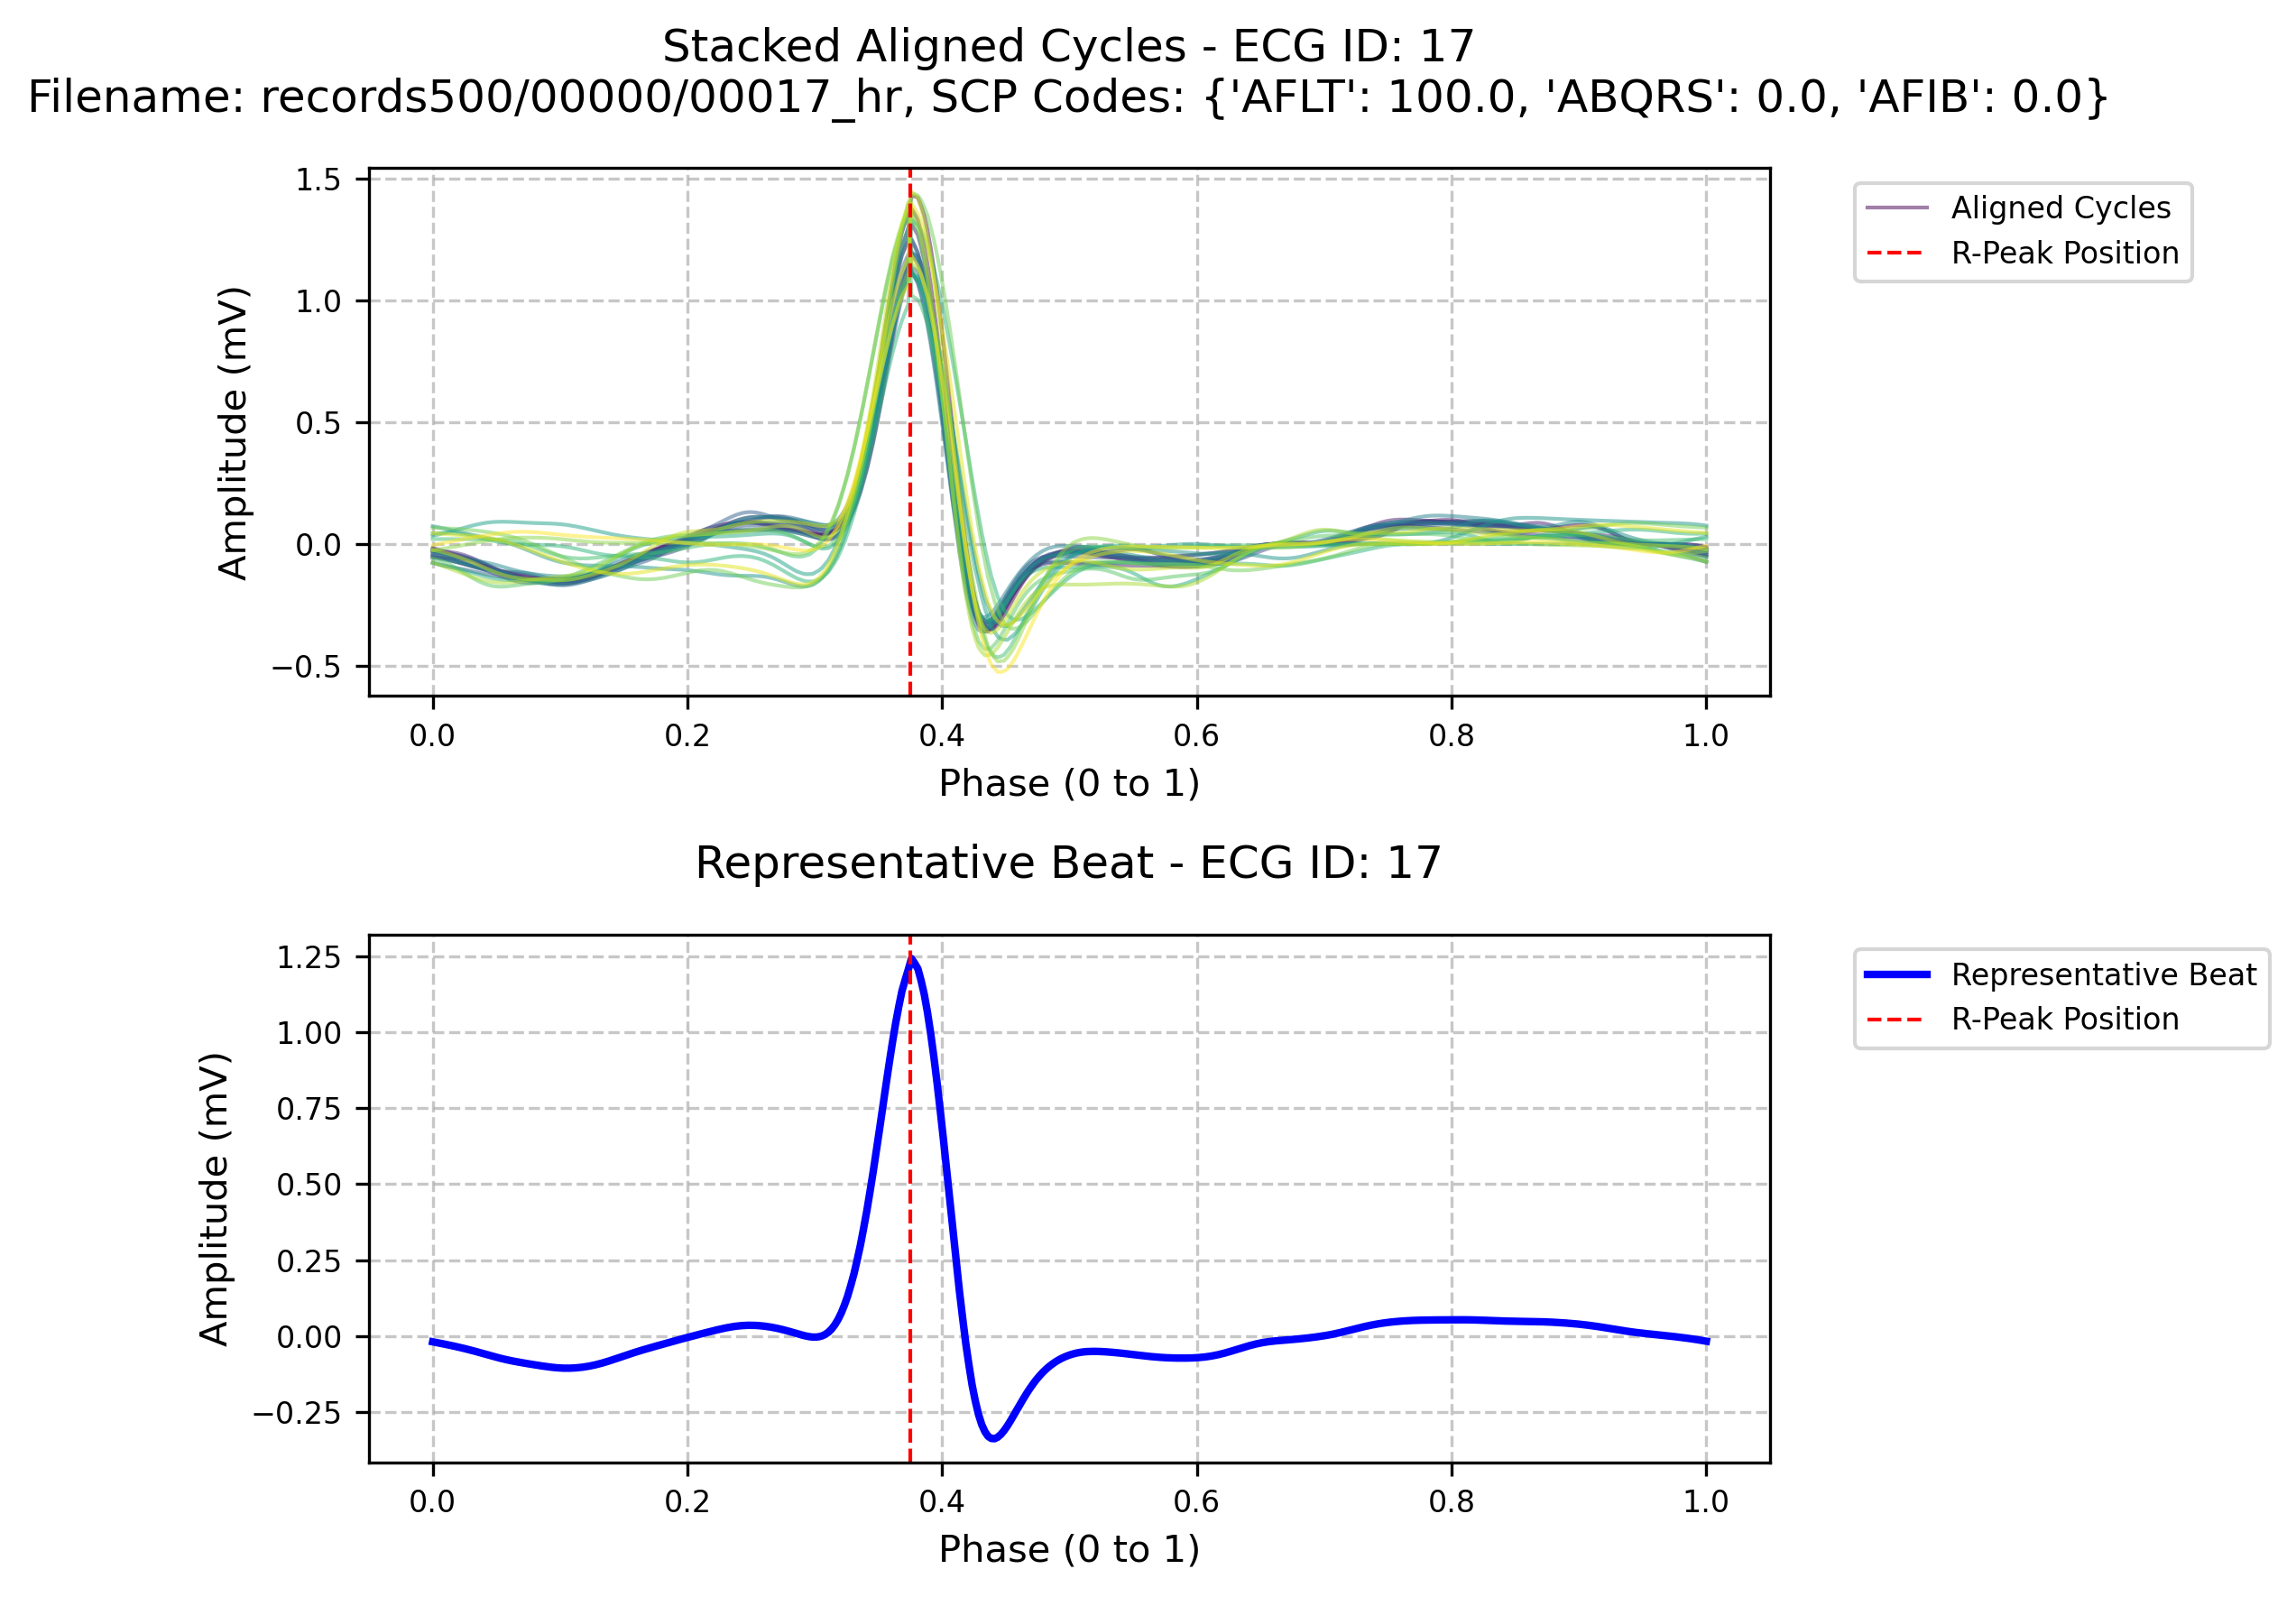

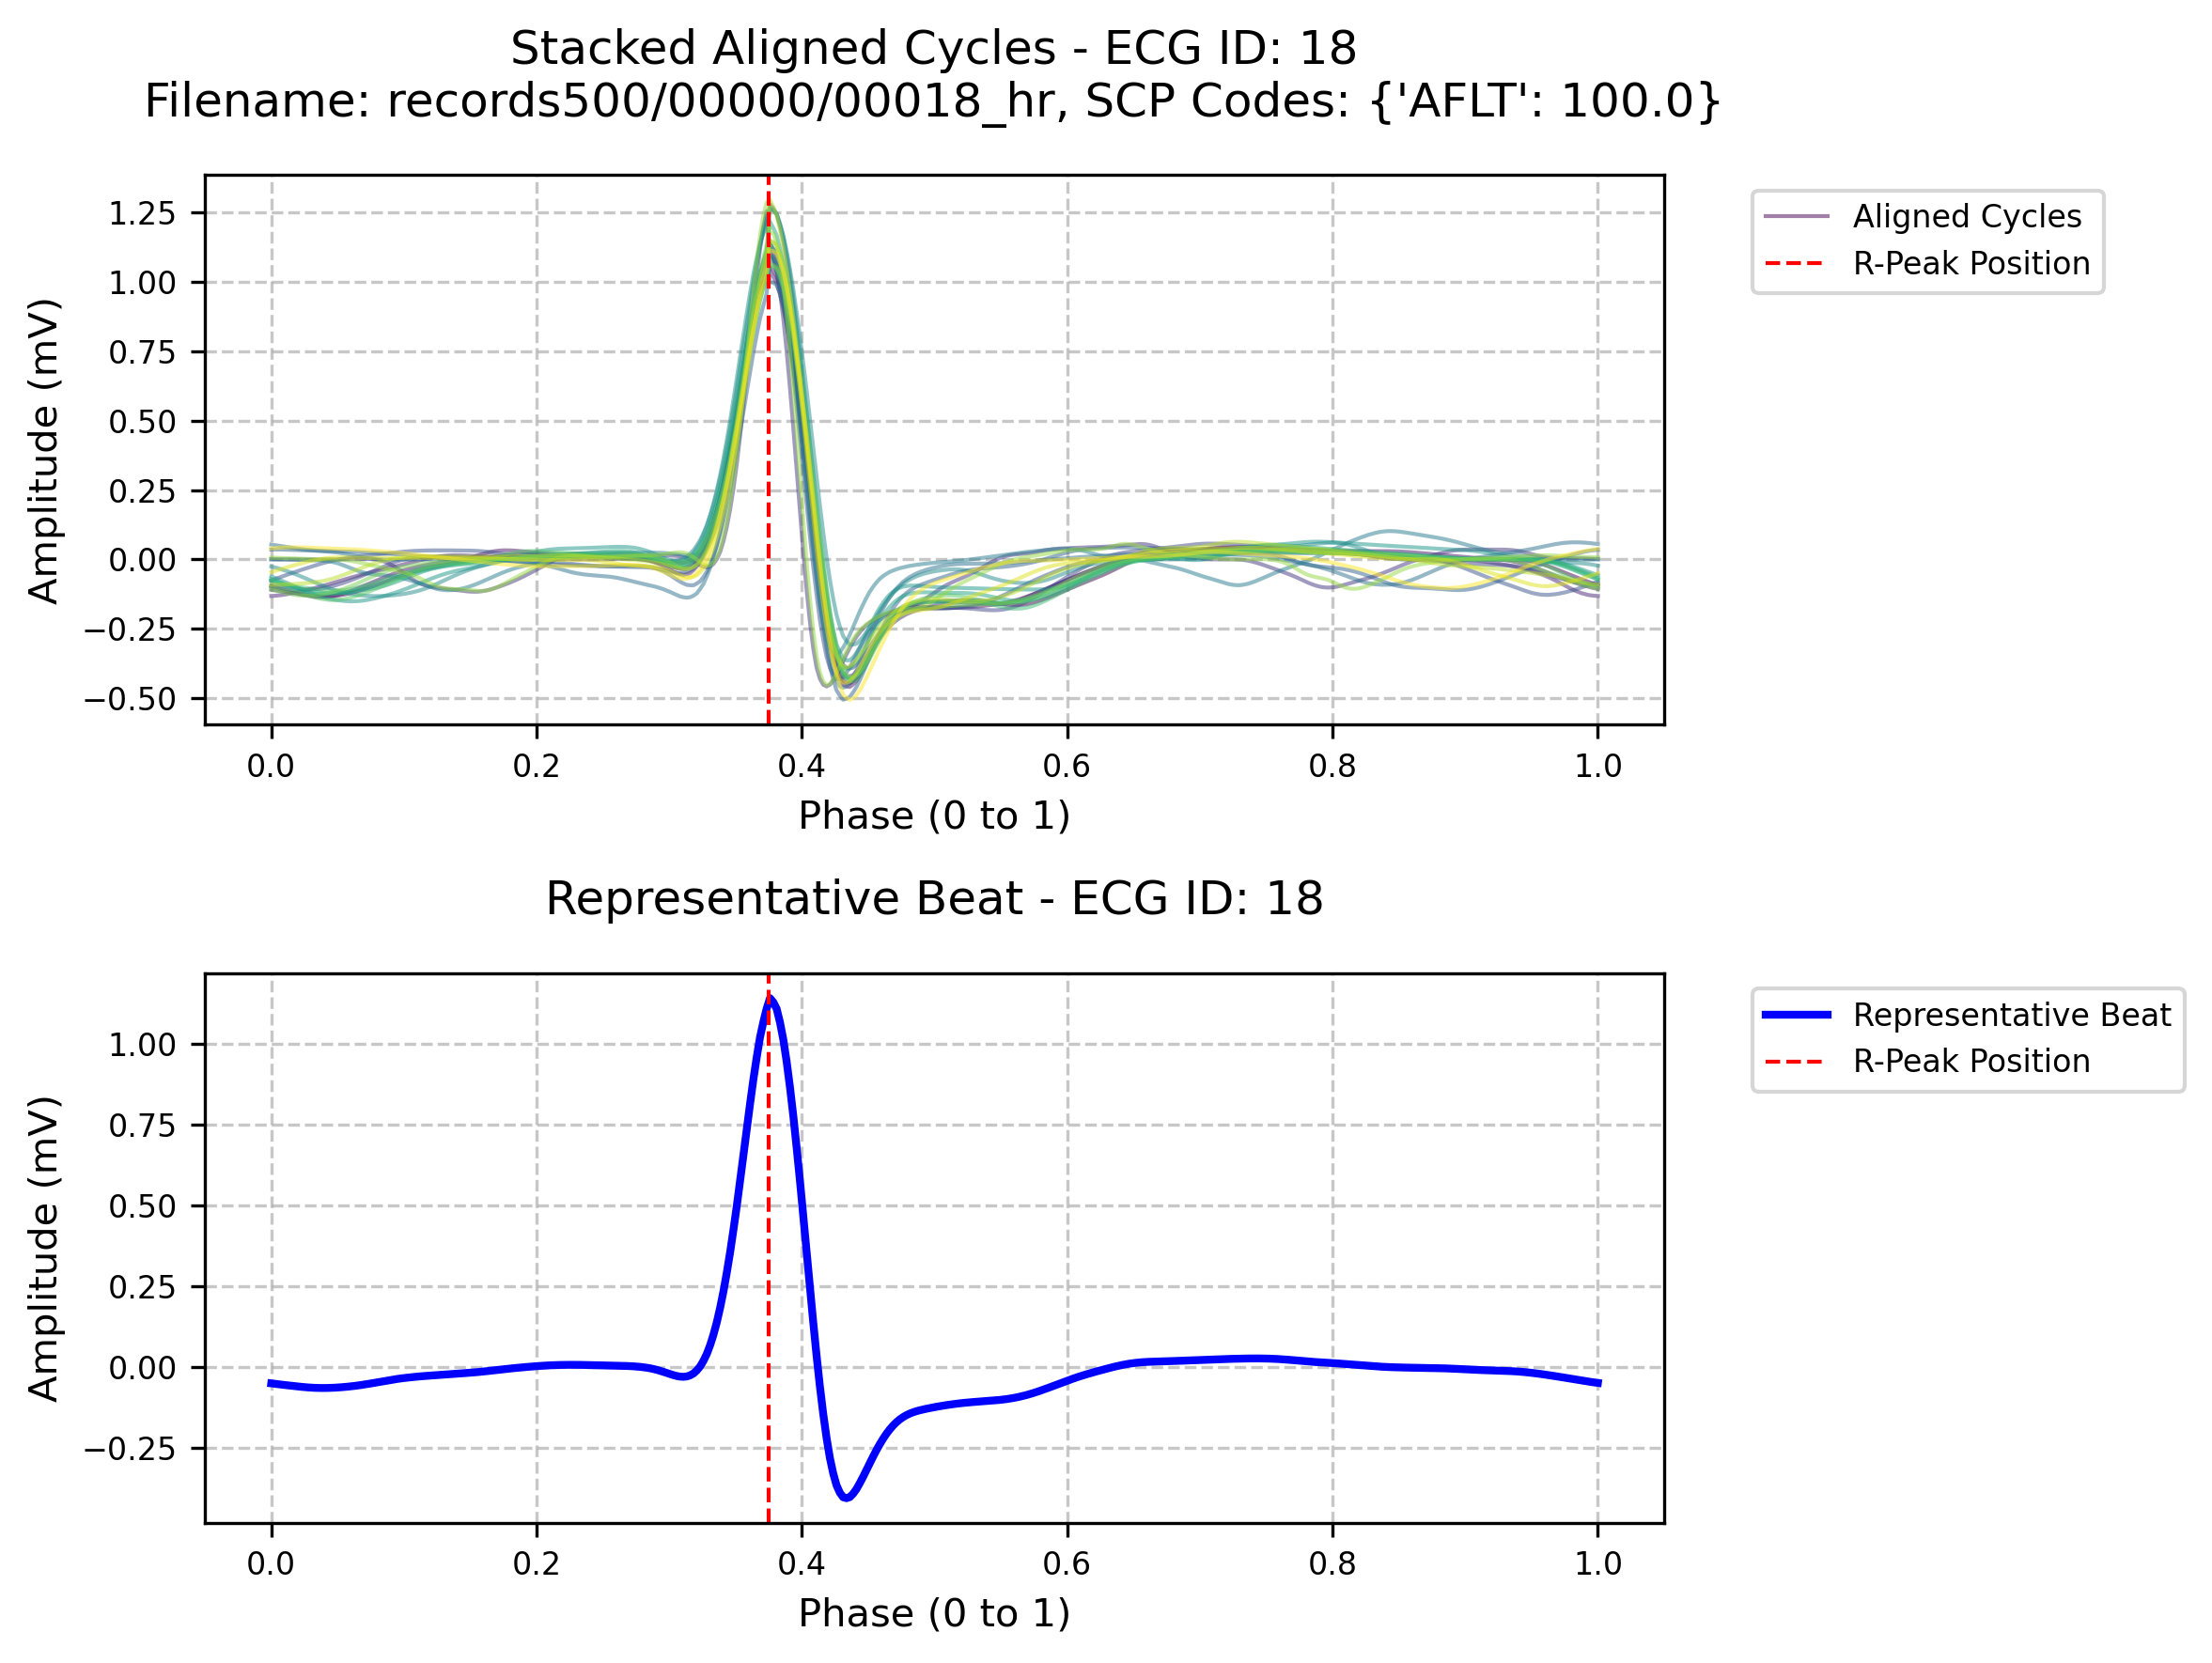

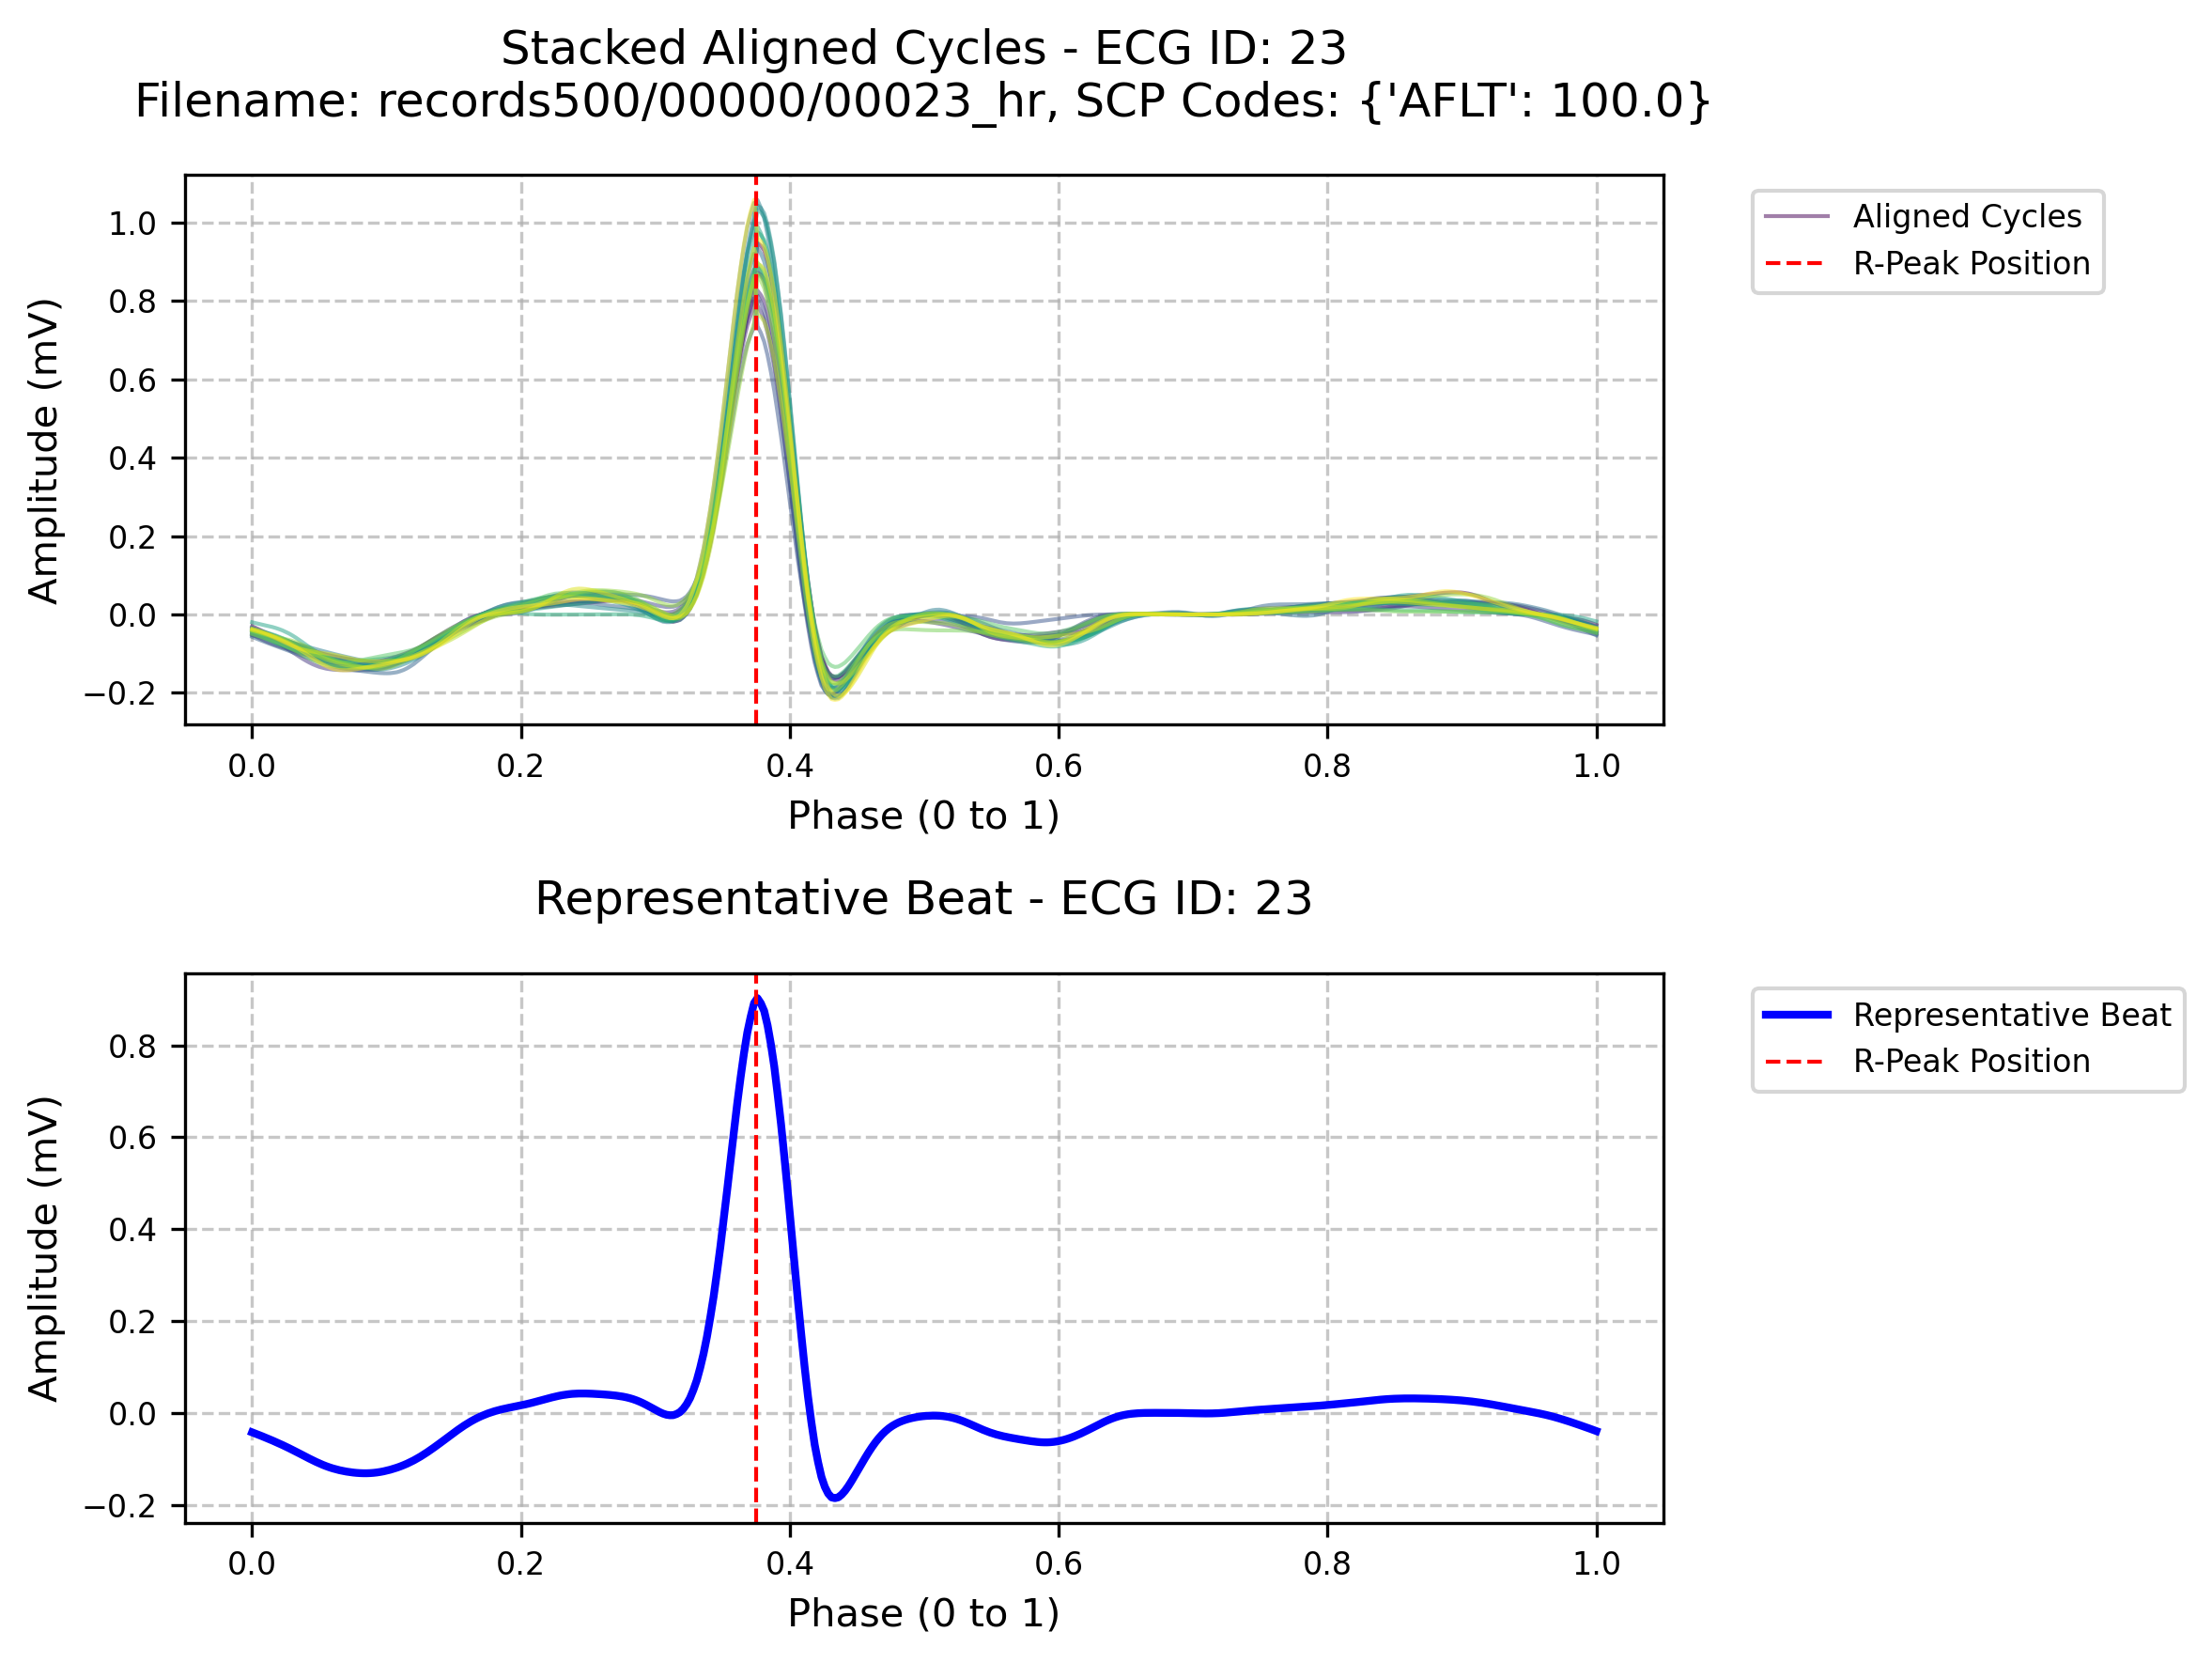

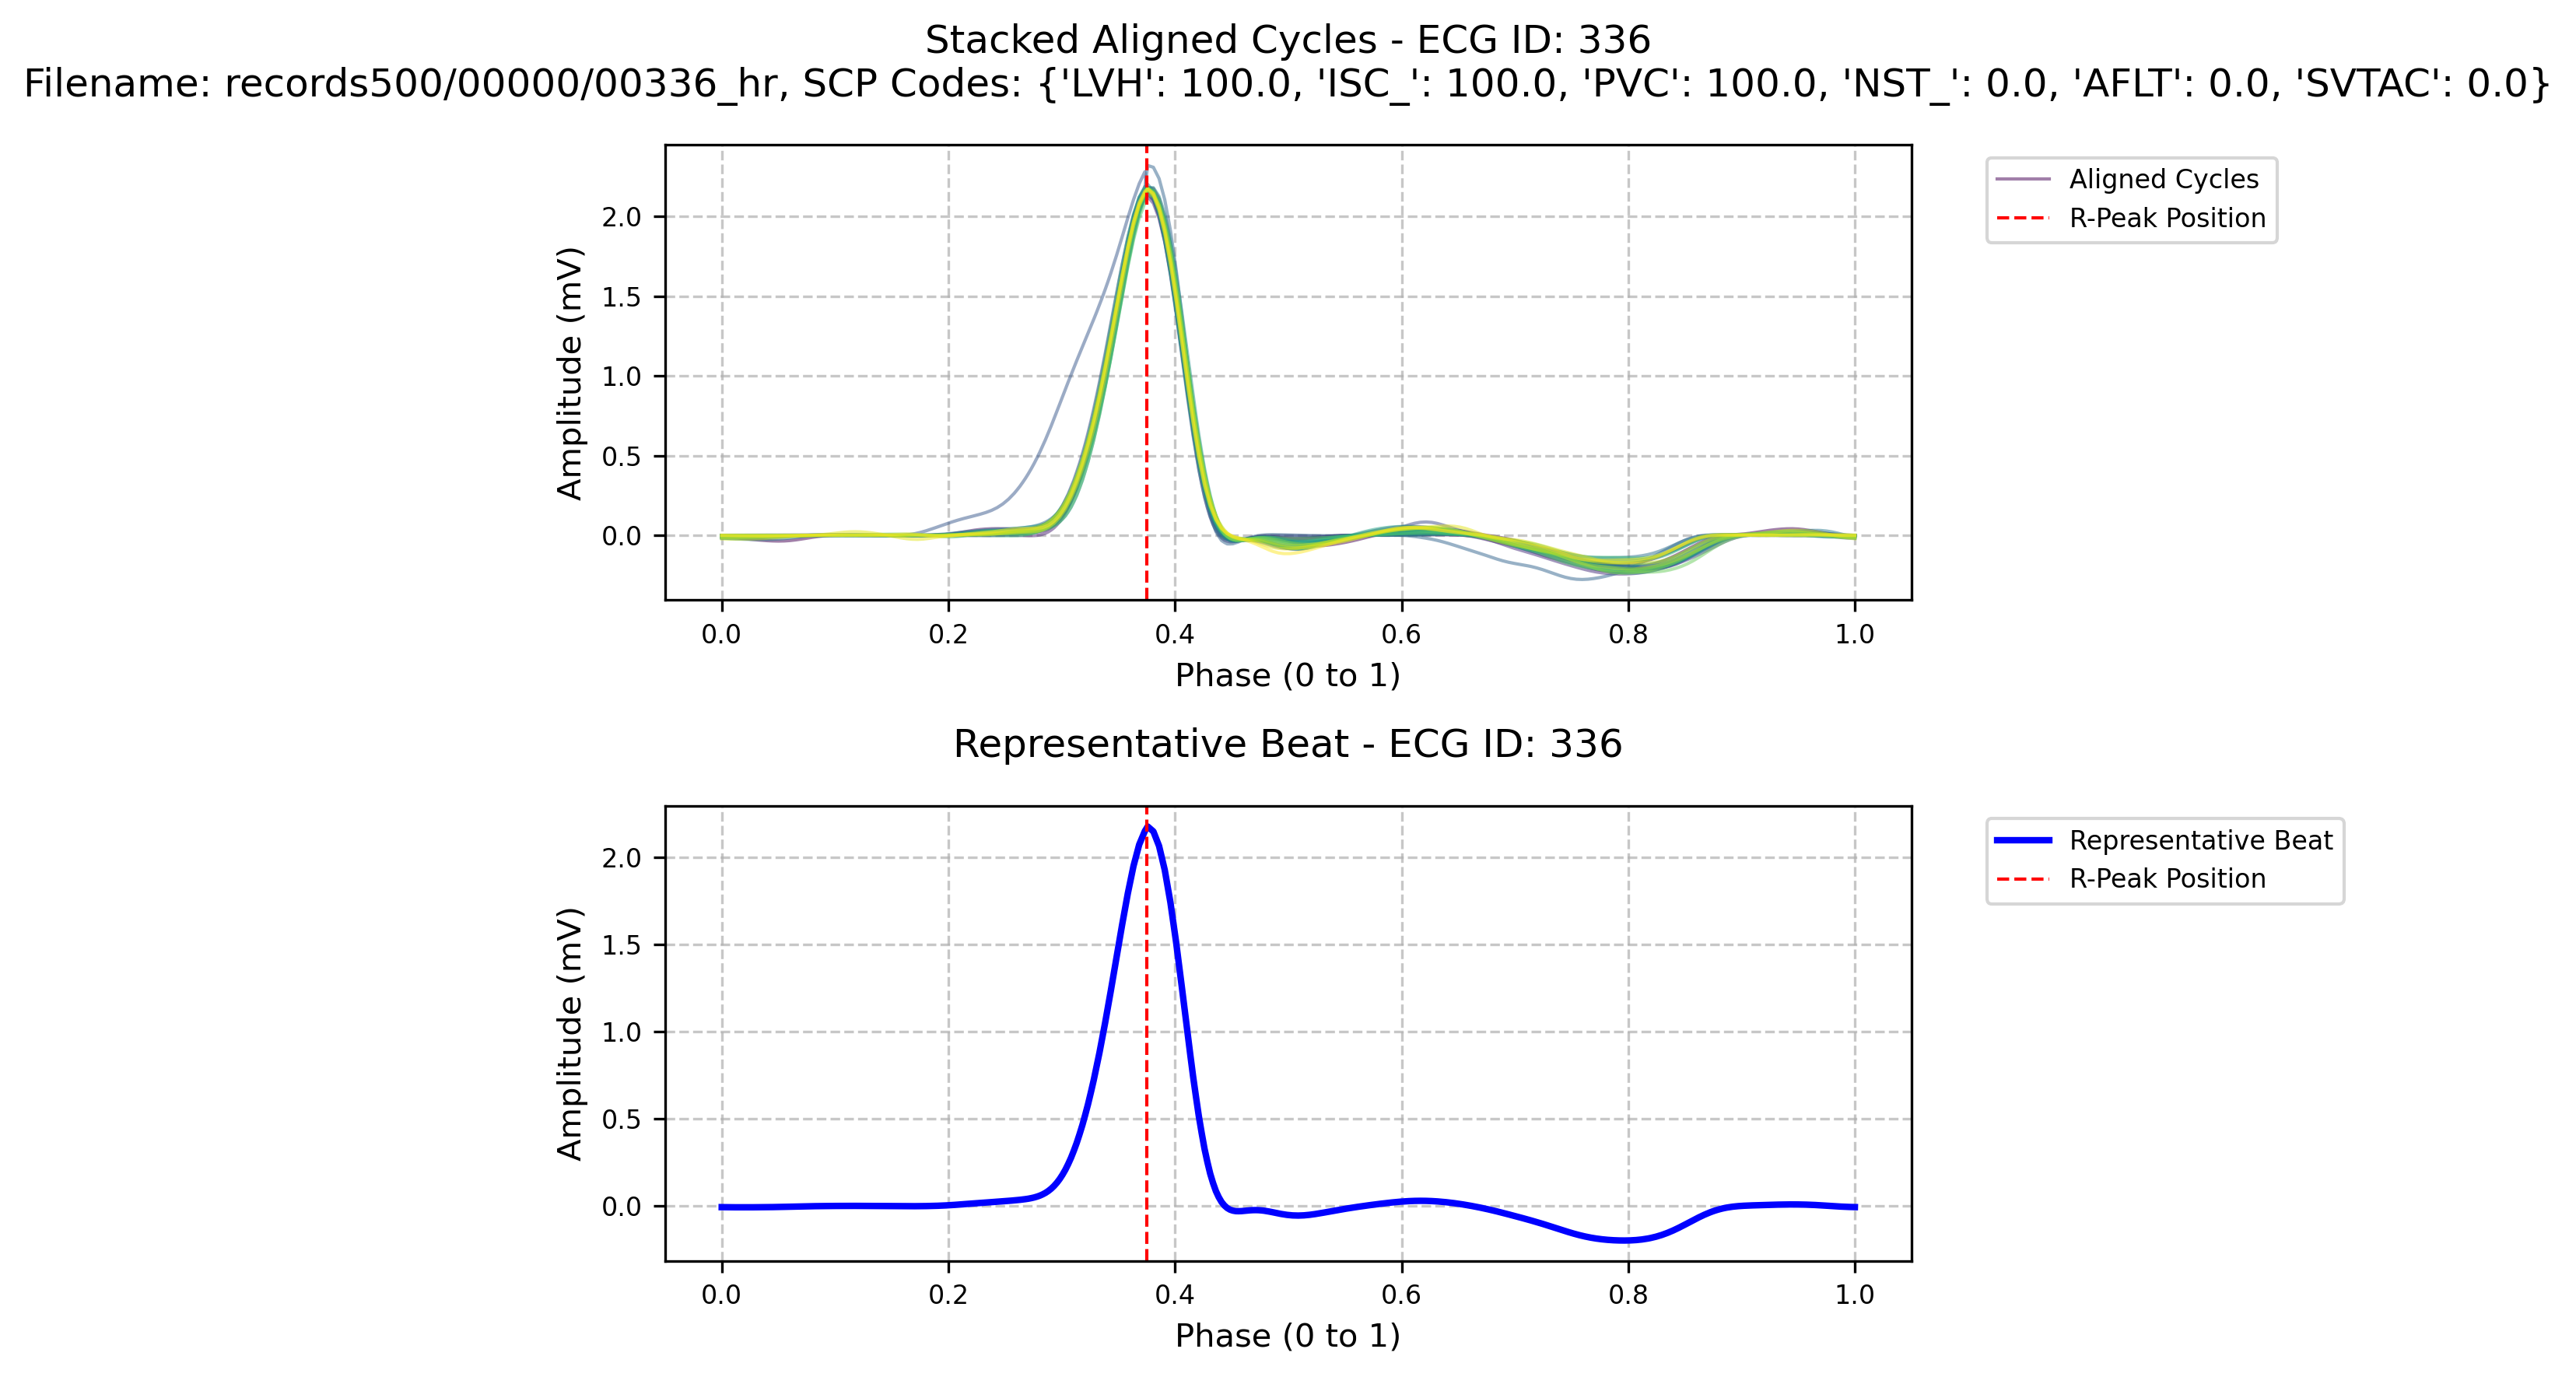

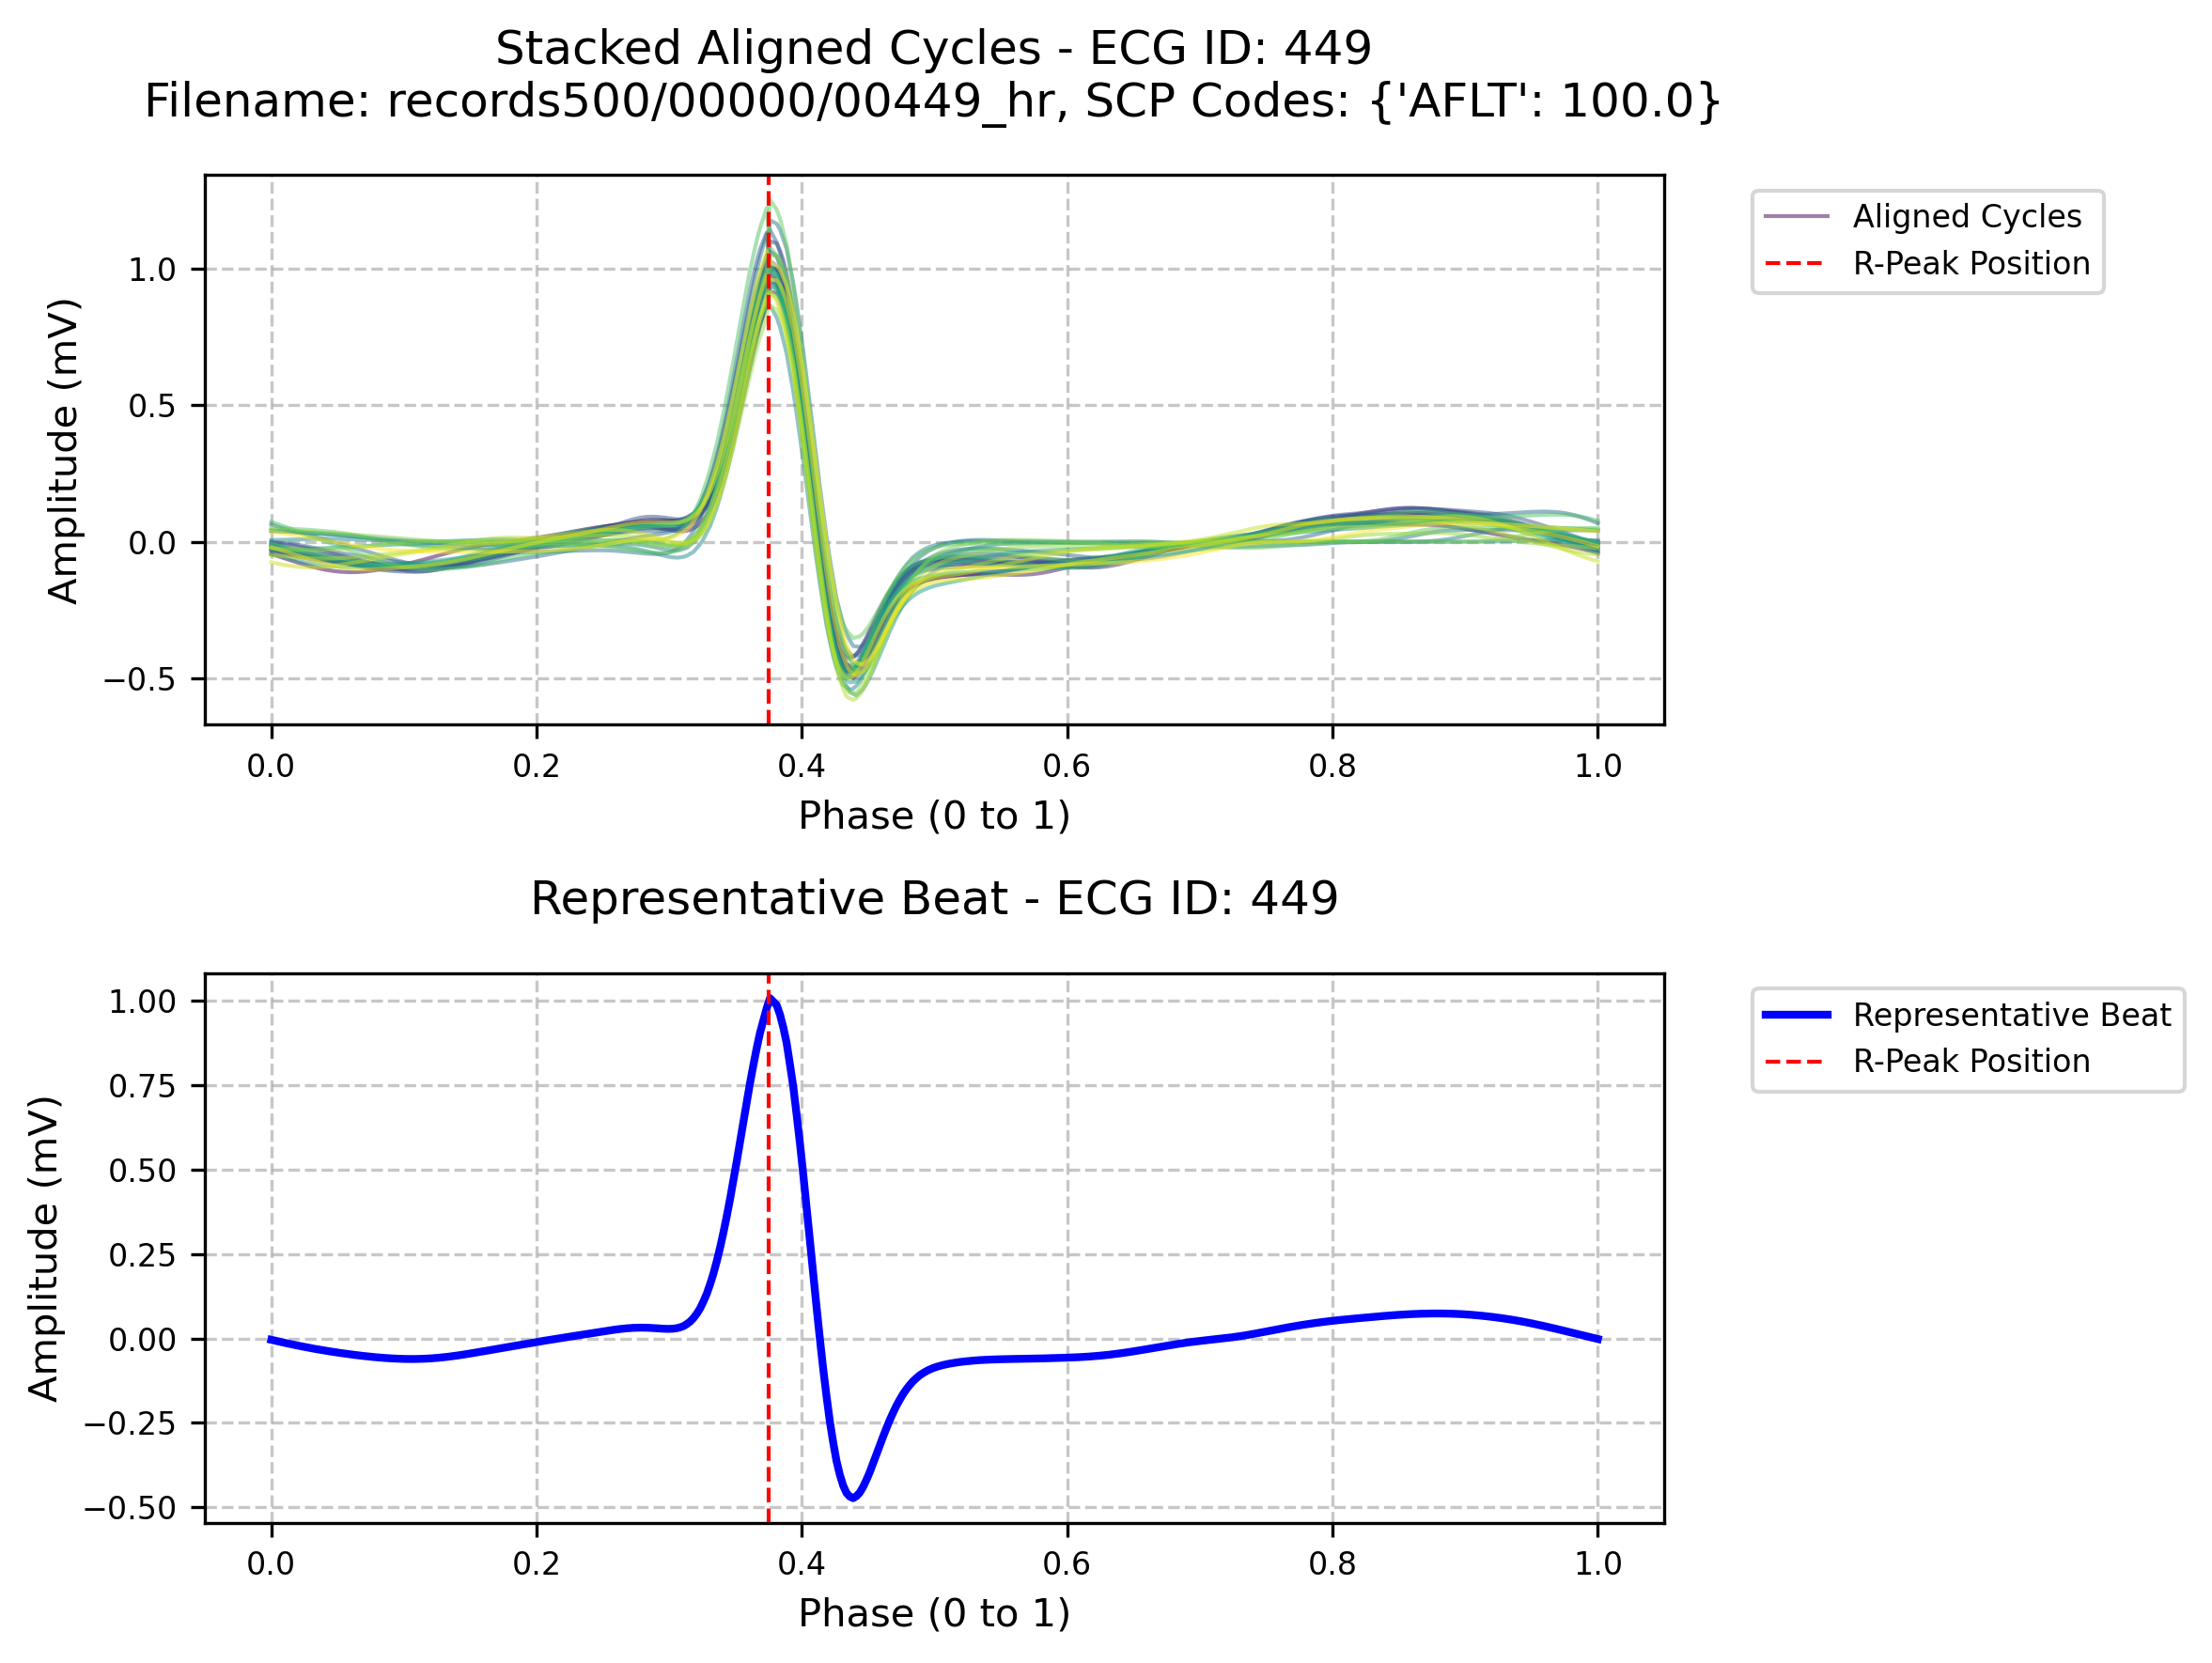

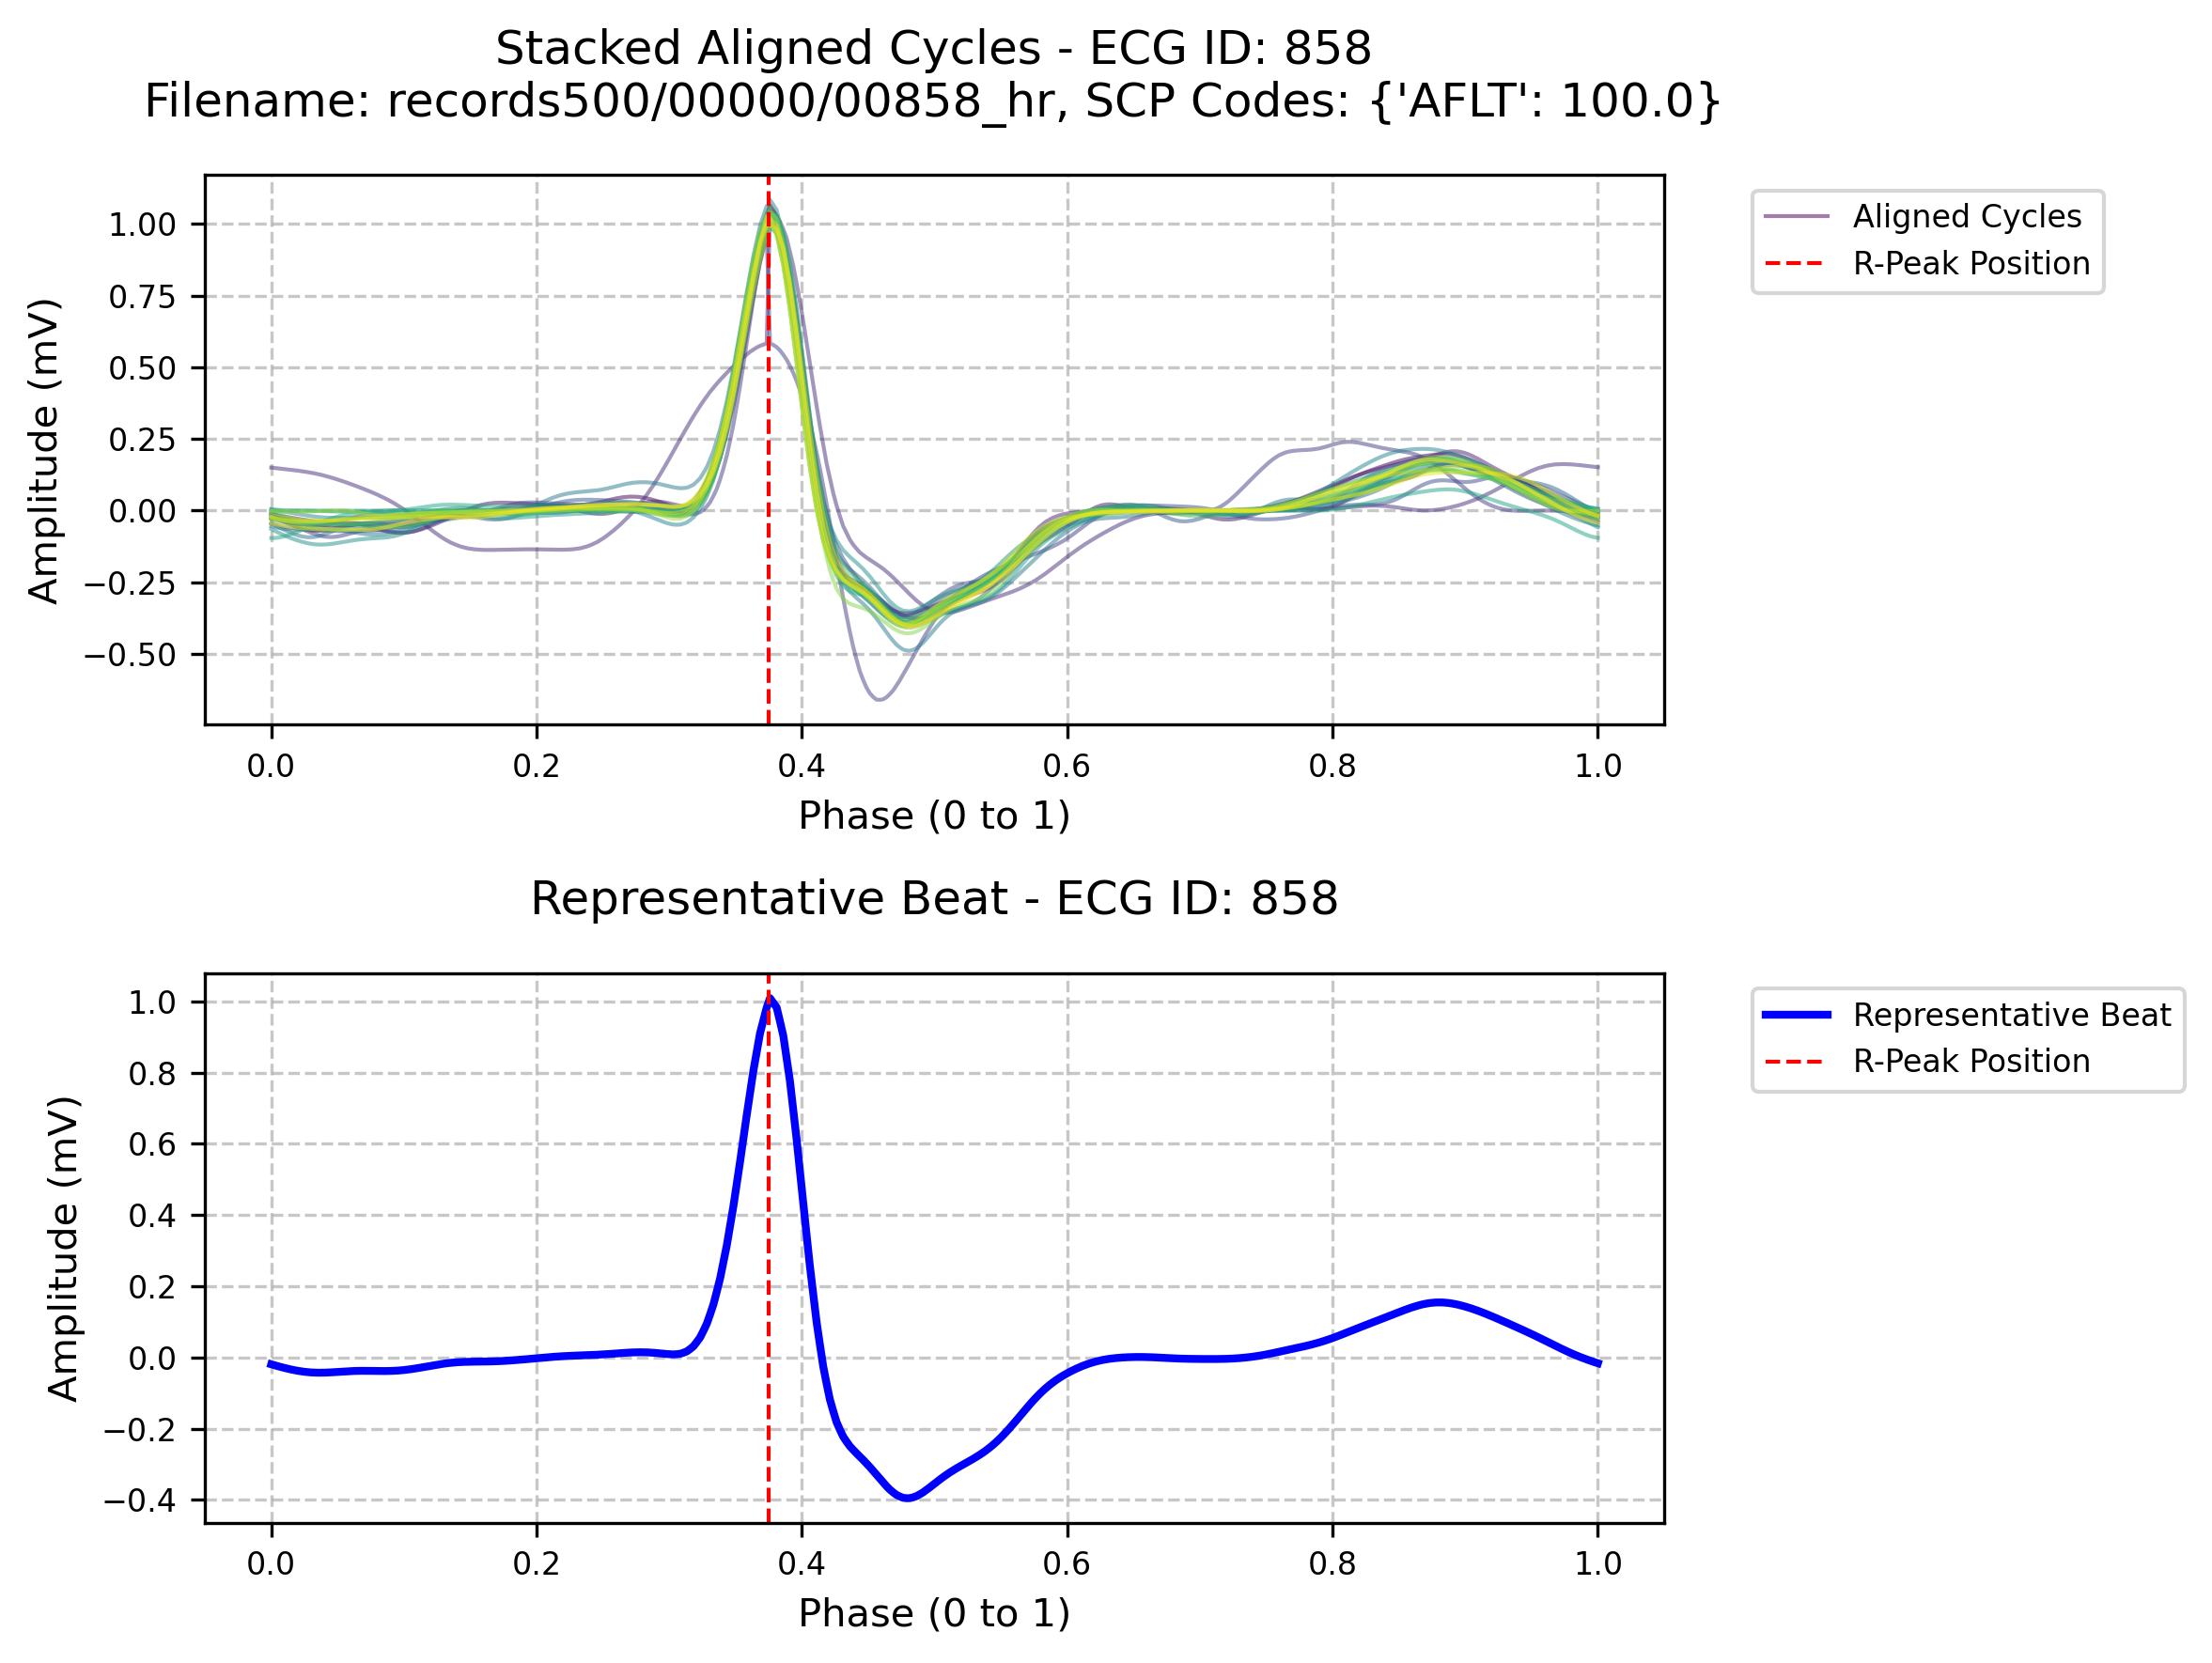

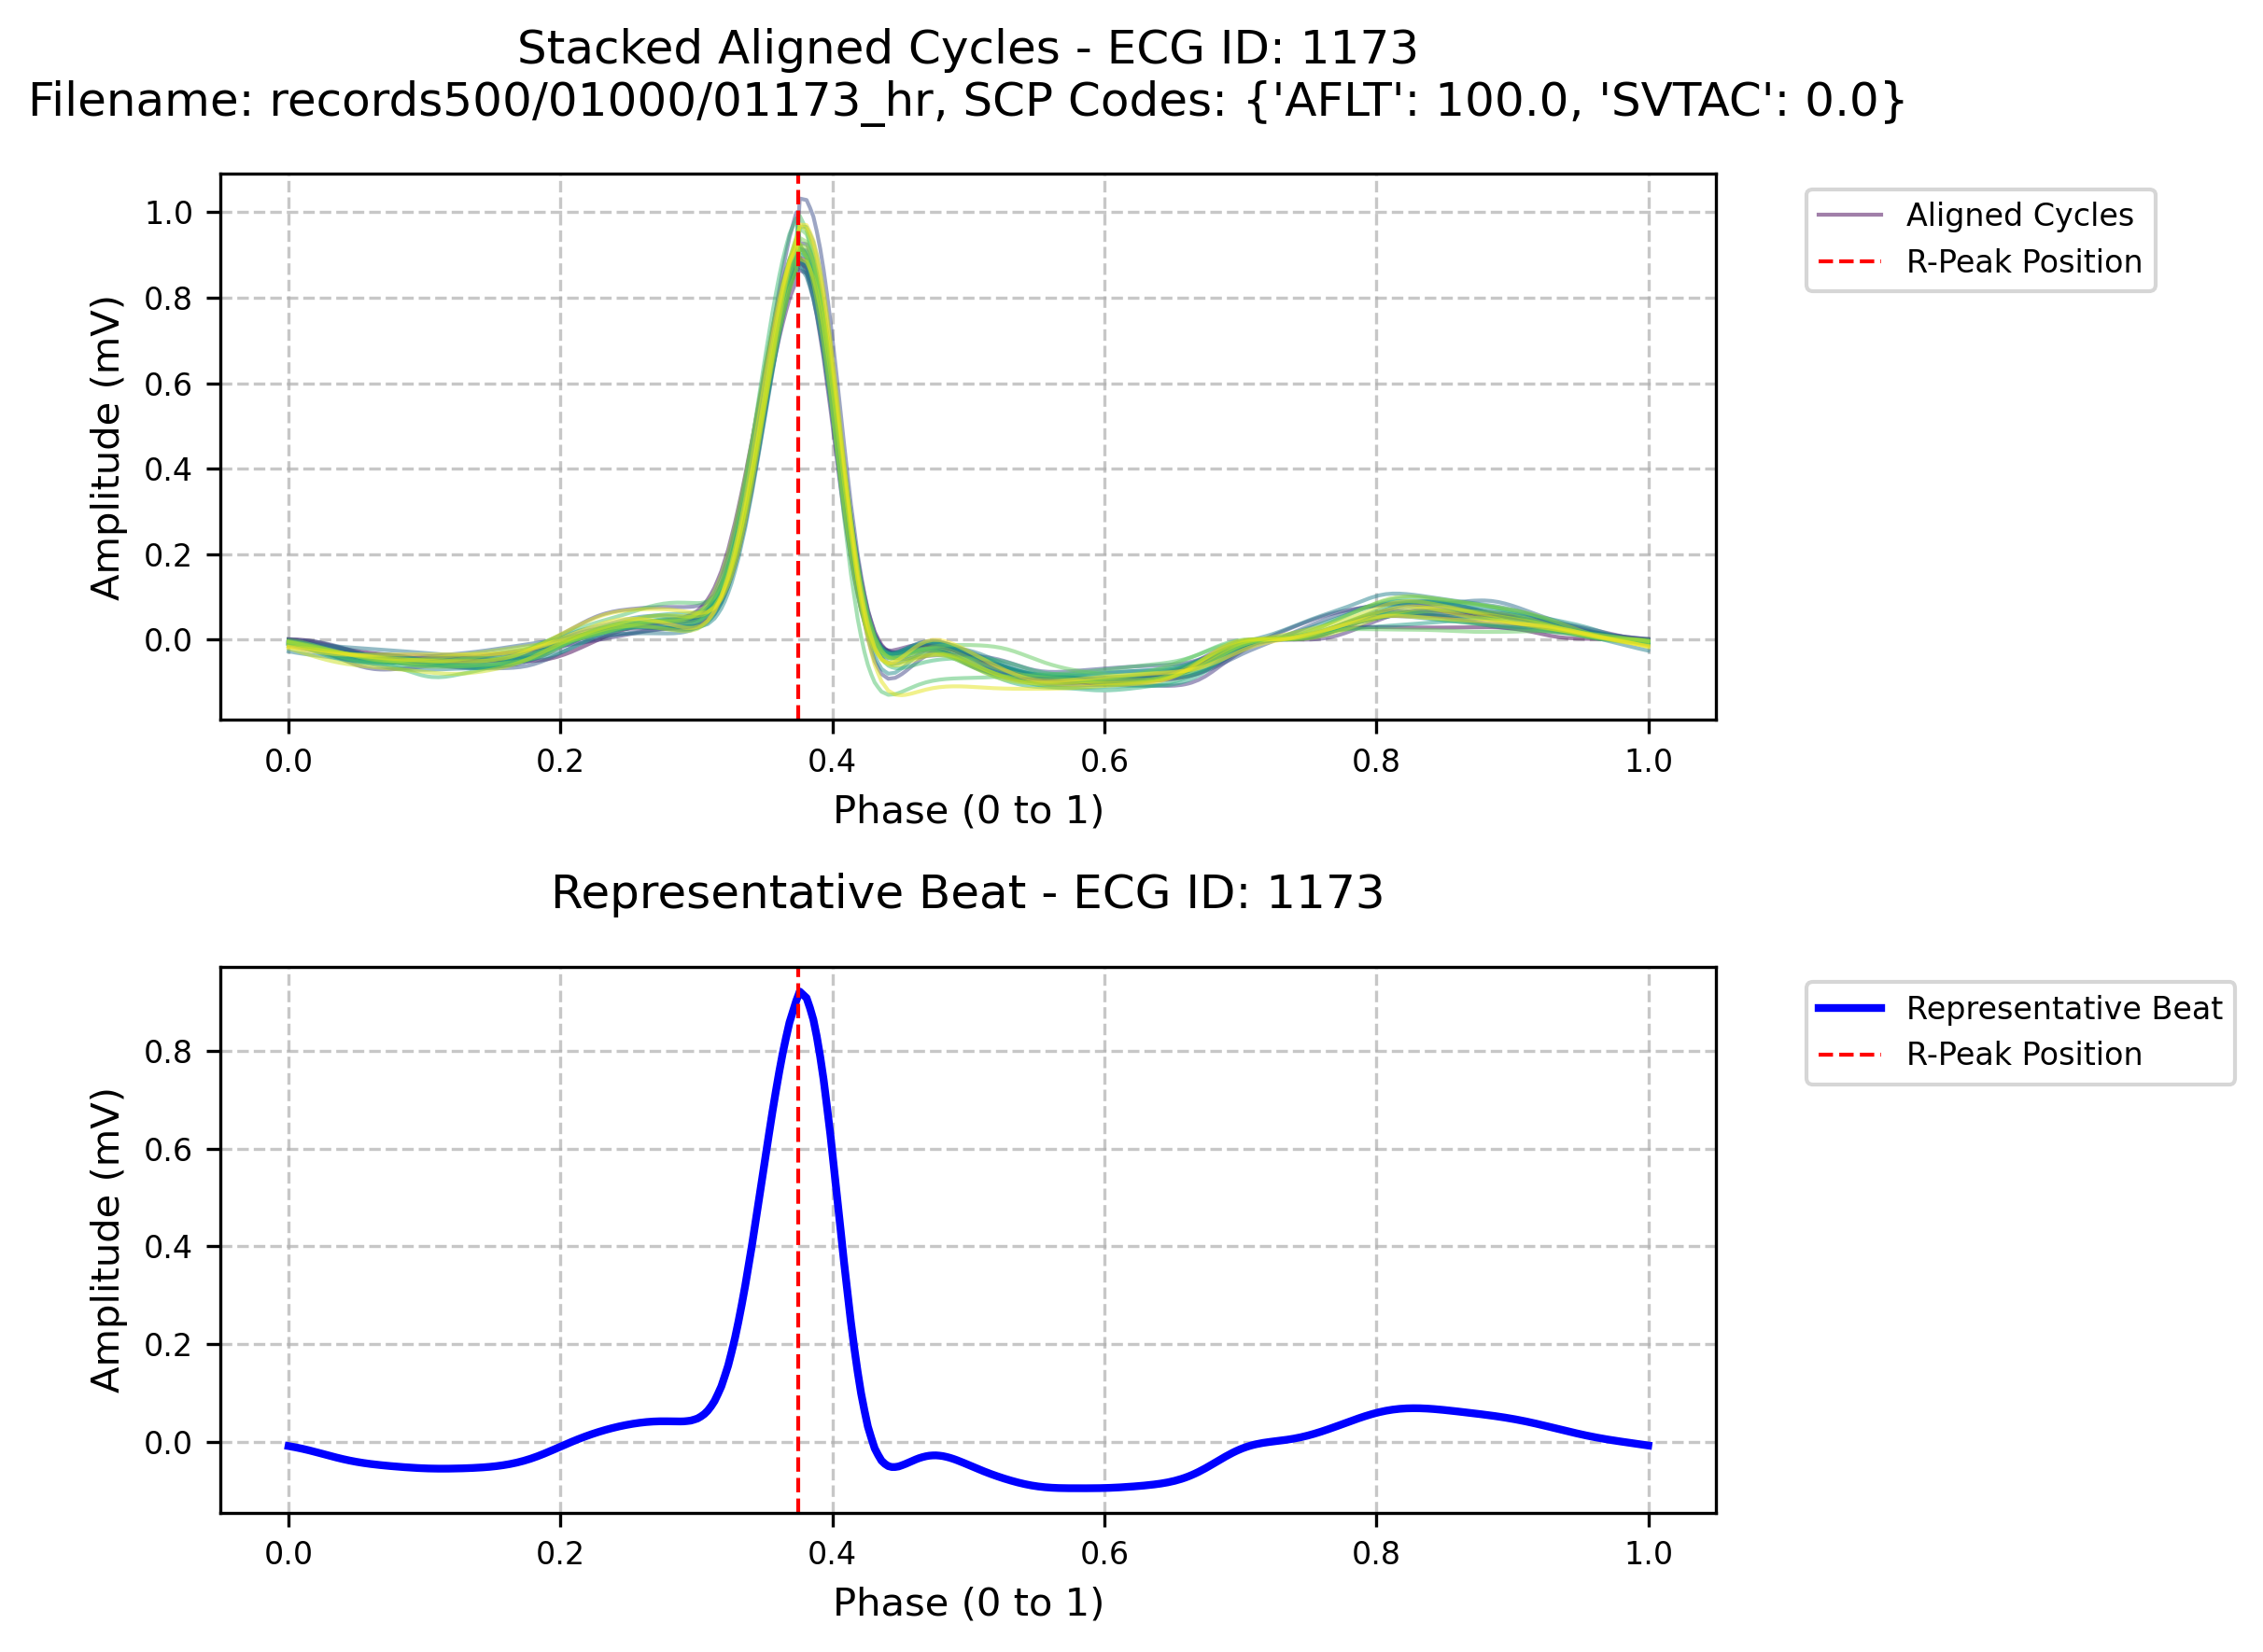

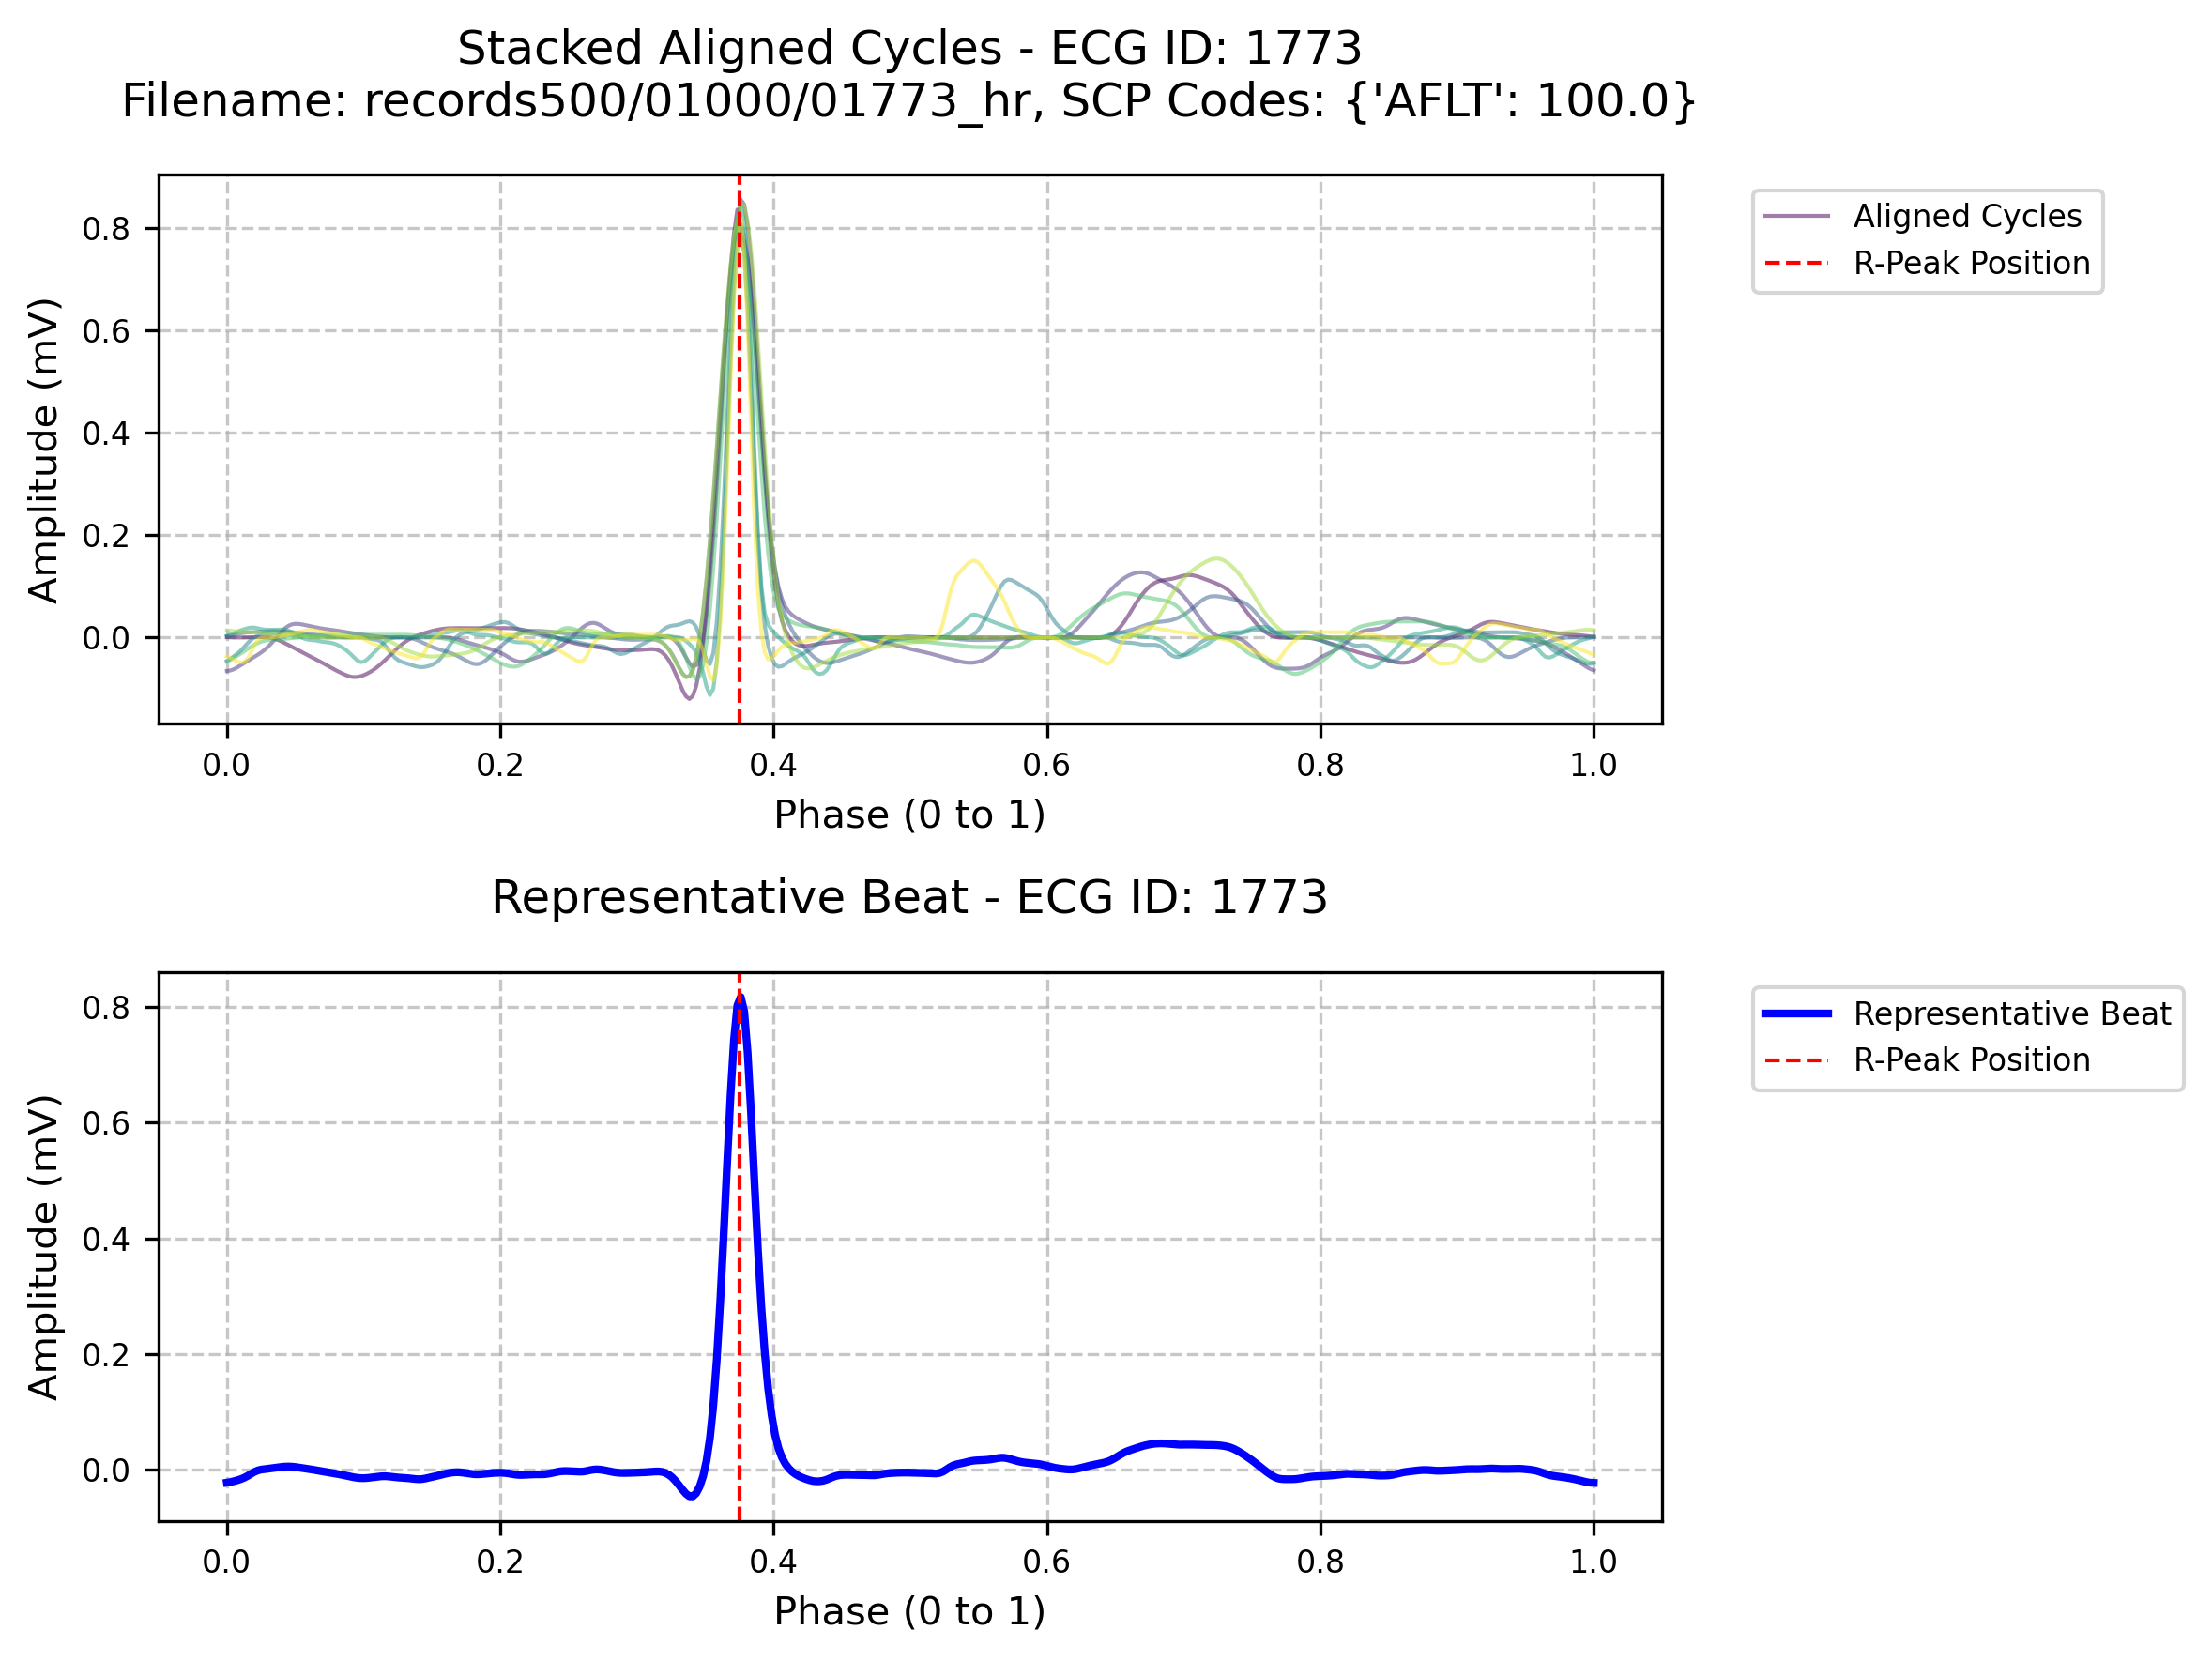


Phase folding for subset complete.
HDF5 file saved at: phase_folded_cycles_subset.h5
CSV file saved at: phase_folded_cycles_subset.csv


In [1]:
import h5py
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv

# Paths
base_path = Path("/Users/rohanmotanavar/datasets/PTB_XL")
csv_path = base_path / "ptbxl_database.csv"
hdf5_lead_v6_path = '/Users/rohanmotanavar/Dissertation ECG Parameterization/Pipeline1_LeadV6_extraction/preprocessed_lead_v6.h5'
hdf5_rpeak_path = '/Users/rohanmotanavar/Dissertation ECG Parameterization/Pipeline2_R_Peak_detection/rpeak_detection_results.h5'
hdf5_output_path = 'phase_folded_cycles_subset.h5'
csv_output_path = 'phase_folded_cycles_subset.csv'

# List of specific records to test
records_to_test = [
    "records500/00000/00017_hr",
    "records500/00000/00018_hr",
    "records500/00000/00023_hr",
    "records500/00000/00336_hr",
    "records500/00000/00449_hr",
    "records500/00000/00858_hr",
    "records500/01000/01173_hr",
    "records500/01000/01773_hr"
]

# Load CSV to map filename_hr to ecg_id
print("Loading ptbxl_database.csv to map filename_hr to ecg_id...")
df = pd.read_csv(csv_path)
filename_to_ecg_id = dict(zip(df['filename_hr'], df['ecg_id']))
ecg_id_to_metadata = df.set_index('ecg_id')[['patient_id', 'scp_codes', 'age', 'sex']].to_dict('index')

# Map the records to their ecg_id values
ecg_ids_to_test = []
for filename_hr in records_to_test:
    if filename_hr in filename_to_ecg_id:
        ecg_id = filename_to_ecg_id[filename_hr]
        ecg_ids_to_test.append(str(ecg_id))  # Convert to string for HDF5 key
    else:
        print(f"Warning: {filename_hr} not found in ptbxl_database.csv")

# Initialize CSV file with headers
csv_headers = [
    'ecg_id', 'patient_id', 'filename_hr', 'number_of_rpeaks', 'mean_heart_rate',
    'mean_rr_interval', 'rr_std', 'number_of_cycles', 'aligned_cycles',
    'representative_beat', 'scp_codes', 'age', 'sex'
]
with open(csv_output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_headers)

# Fixed length for normalized cycles
normalized_length = 400  # Number of samples in the phase-folded cycle
rpeak_phase = 0.375  # Desired phase for R-peak (150/400)
rpeak_position = int(normalized_length * rpeak_phase)  # Sample position for R-peak

# Process the subset and visualize
print(f"\nProcessing subset of {len(ecg_ids_to_test)} records for phase folding...")
with h5py.File(hdf5_lead_v6_path, 'r') as h5_lead, h5py.File(hdf5_rpeak_path, 'r') as h5_rpeak, h5py.File(hdf5_output_path, 'w') as h5_out:
    for ecg_id in ecg_ids_to_test:
        if ecg_id not in h5_rpeak:
            print(f"ecg_id {ecg_id} not found in rpeak_detection_results.h5")
            continue
        
        # Load preprocessed Lead V6 signal
        lead_v6 = h5_lead[ecg_id][:]
        
        # Load R-peak data and metadata
        rpeak_grp = h5_rpeak[ecg_id]
        rpeak_indices = rpeak_grp['rpeak_indices'][:]
        patient_id = rpeak_grp.attrs['patient_id']
        filename_hr = rpeak_grp.attrs['filename_hr']
        number_of_rpeaks = rpeak_grp.attrs['number_of_rpeaks']
        mean_heart_rate = rpeak_grp.attrs['mean_heart_rate']
        mean_rr_interval = rpeak_grp.attrs['mean_rr_interval']
        rr_std = rpeak_grp.attrs['rr_std']
        
        # Get additional metadata
        meta = ecg_id_to_metadata.get(int(ecg_id), {})
        scp_codes = str(meta.get('scp_codes', 'Unknown'))
        age = meta.get('age', np.nan)
        sex = meta.get('sex', 'Unknown')
        
        # Extract and align cycles using RR intervals
        aligned_cycles = []
        number_of_cycles = max(0, number_of_rpeaks - 1)
        
        if number_of_cycles > 0:
            for i in range(number_of_cycles):
                start_idx = rpeak_indices[i]
                end_idx = rpeak_indices[i + 1]
                cycle = lead_v6[start_idx:end_idx]
                
                # Normalize the cycle to phase 0 to 1
                original_length = end_idx - start_idx
                if original_length <= 1:  # Skip if cycle is too short
                    continue
                original_phase = np.linspace(0, 1, original_length)
                target_phase = np.linspace(0, 1, normalized_length)
                
                # Interpolate the cycle to the target length
                interpolator = interp1d(original_phase, cycle, kind='linear', fill_value="extrapolate")
                normalized_cycle = interpolator(target_phase)
                
                # Shift the cycle to align the R-peak at the desired phase
                rpeak_sample = int(original_length * (rpeak_indices[i] - start_idx) / original_length)
                shift = rpeak_position - int(normalized_length * (rpeak_sample / original_length))
                shifted_cycle = np.roll(normalized_cycle, shift)
                
                aligned_cycles.append(shifted_cycle)
        
        # Convert to numpy array
        if len(aligned_cycles) > 0:
            aligned_cycles = np.array(aligned_cycles)
            # Compute the representative beat
            representative_beat = np.mean(aligned_cycles, axis=0)
        else:
            aligned_cycles = np.zeros((1, normalized_length))
            representative_beat = np.zeros(normalized_length)
        
        # Create group for this ecg_id in HDF5
        grp = h5_out.create_group(ecg_id)
        
        # Store datasets in HDF5
        grp.create_dataset('aligned_cycles', data=aligned_cycles)
        grp.create_dataset('representative_beat', data=representative_beat)
        
        # Store attributes in HDF5
        grp.attrs['ecg_id'] = ecg_id
        grp.attrs['patient_id'] = patient_id
        grp.attrs['filename_hr'] = filename_hr
        grp.attrs['number_of_rpeaks'] = number_of_rpeaks
        grp.attrs['mean_heart_rate'] = mean_heart_rate
        grp.attrs['mean_rr_interval'] = mean_rr_interval
        grp.attrs['rr_std'] = rr_std
        grp.attrs['number_of_cycles'] = len(aligned_cycles)
        grp.attrs['scp_codes'] = scp_codes
        grp.attrs['age'] = age
        grp.attrs['sex'] = sex
        
        # Serialize arrays for CSV
        aligned_cycles_str = ';'.join([','.join(map(str, cycle)) for cycle in aligned_cycles])
        representative_beat_str = ','.join(map(str, representative_beat))
        
        # Append to CSV
        with open(csv_output_path, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                ecg_id, patient_id, filename_hr, number_of_rpeaks,
                mean_heart_rate if not np.isnan(mean_heart_rate) else 'NaN',
                mean_rr_interval if not np.isnan(mean_rr_interval) else 'NaN',
                rr_std if not np.isnan(rr_std) else 'NaN',
                len(aligned_cycles), aligned_cycles_str, representative_beat_str,
                scp_codes, age, sex
            ])
        
        # Visualize the results with thesis-worthy aesthetics
        phase = np.linspace(0, 1, normalized_length)
        
        # Use a professional colormap for the aligned cycles
        colors = plt.cm.viridis(np.linspace(0, 1, len(aligned_cycles)))
        
        # Create the figure with adjusted size and DPI for high quality
        plt.figure(figsize=(8, 6), dpi=300)
        
        # Top subplot: Stacked Aligned Cycles
        plt.subplot(2, 1, 1)
        for i, cycle in enumerate(aligned_cycles):
            plt.plot(phase, cycle, color=colors[i], alpha=0.5, linewidth=1, label="Aligned Cycles" if i == 0 else None)
        plt.axvline(x=rpeak_phase, color='red', linestyle='--', linewidth=1, label='R-Peak Position')
        plt.title(f"Stacked Aligned Cycles - ECG ID: {ecg_id}\nFilename: {filename_hr}, SCP Codes: {scp_codes}", fontsize=12, pad=15)
        plt.xlabel("Phase (0 to 1)", fontsize=10)
        plt.ylabel("Amplitude (mV)", fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        plt.tick_params(axis='both', which='major', labelsize=8)
        
        # Bottom subplot: Representative Beat
        plt.subplot(2, 1, 2)
        plt.plot(phase, representative_beat, color='blue', linewidth=2, label="Representative Beat")
        plt.axvline(x=rpeak_phase, color='red', linestyle='--', linewidth=1, label='R-Peak Position')
        plt.title(f"Representative Beat - ECG ID: {ecg_id}", fontsize=12, pad=15)
        plt.xlabel("Phase (0 to 1)", fontsize=10)
        plt.ylabel("Amplitude (mV)", fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        plt.tick_params(axis='both', which='major', labelsize=8)
        
        # Adjust layout to prevent overlap
        plt.tight_layout()
        
        # Save the figure as a high-resolution image
        plt.savefig(f"phase_folding_ecg_id_{ecg_id}.png", bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()

print(f"\nPhase folding for subset complete.")
print(f"HDF5 file saved at: {hdf5_output_path}")
print(f"CSV file saved at: {csv_output_path}")

# Iterating over entire data set

In [2]:
import h5py
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.interpolate import interp1d
from tqdm import tqdm
import csv

# Paths
base_path = Path("/Users/rohanmotanavar/datasets/PTB_XL")
csv_path = base_path / "ptbxl_database.csv"
hdf5_lead_v6_path = '/Users/rohanmotanavar/Dissertation ECG Parameterization/Pipeline1_LeadV6_extraction/preprocessed_lead_v6.h5'
hdf5_rpeak_path = '/Users/rohanmotanavar/Dissertation ECG Parameterization/Pipeline2_R_Peak_detection/rpeak_detection_results.h5'
hdf5_output_path = 'phase_folded_results.h5'
csv_output_path = 'phase_folded_results.csv'

# Load CSV for metadata
print("Loading ptbxl_database.csv...")
df = pd.read_csv(csv_path)
filename_to_ecg_id = dict(zip(df['filename_hr'], df['ecg_id']))
ecg_id_to_metadata = df.set_index('ecg_id')[['patient_id', 'scp_codes', 'age', 'sex']].to_dict('index')

# Initialize CSV file with headers
csv_headers = [
    'ecg_id', 'patient_id', 'filename_hr', 'representative_beat',
    'mean_heart_rate', 'mean_rr_interval', 'rr_std', 'number_of_rpeaks',
    'scp_codes', 'age', 'sex'
]
with open(csv_output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_headers)

# Phase-folding parameters
normalized_length = 400  # Number of samples in the phase-folded beat
rpeak_phase = 0.375  # Desired phase for R-peak (150/400)
rpeak_position = int(normalized_length * rpeak_phase)  # Sample position for R-peak

# Process the entire dataset with a progress bar
print(f"\nProcessing all records for phase folding from {hdf5_lead_v6_path}...")
with h5py.File(hdf5_lead_v6_path, 'r') as h5_lead, \
     h5py.File(hdf5_rpeak_path, 'r') as h5_rpeak, \
     h5py.File(hdf5_output_path, 'w') as h5_out:
    
    # Use tqdm to create a progress bar
    ecg_ids = list(h5_lead.keys())
    for ecg_id in tqdm(ecg_ids, desc="Processing ECG records", unit="record"):
        try:
            # Load preprocessed Lead V6 signal
            lead_v6 = h5_lead[ecg_id][:]
            
            # Load R-peak data and metadata
            if ecg_id not in h5_rpeak:
                print(f"Warning: ecg_id {ecg_id} not found in rpeak_detection_results.h5")
                continue
            rpeak_grp = h5_rpeak[ecg_id]
            rpeak_indices = rpeak_grp['rpeak_indices'][:]
            patient_id = rpeak_grp.attrs['patient_id']
            filename_hr = rpeak_grp.attrs['filename_hr']
            mean_heart_rate = rpeak_grp.attrs['mean_heart_rate']
            mean_rr_interval = rpeak_grp.attrs['mean_rr_interval']
            rr_std = rpeak_grp.attrs['rr_std']
            number_of_rpeaks = rpeak_grp.attrs['number_of_rpeaks']
            
            # Get additional metadata from CSV
            meta = ecg_id_to_metadata.get(int(ecg_id), {})
            scp_codes = str(meta.get('scp_codes', 'Unknown'))
            age = meta.get('age', np.nan)
            sex = meta.get('sex', 'Unknown')
            
            # Phase folding to compute representative beat
            aligned_cycles = []
            number_of_cycles = max(0, number_of_rpeaks - 1)
            
            if number_of_cycles > 0:
                for i in range(number_of_cycles):
                    start_idx = rpeak_indices[i]
                    end_idx = rpeak_indices[i + 1]
                    cycle = lead_v6[start_idx:end_idx]
                    
                    # Normalize the cycle to phase 0 to 1
                    original_length = end_idx - start_idx
                    if original_length <= 1:  # Skip if cycle is too short
                        continue
                    original_phase = np.linspace(0, 1, original_length)
                    target_phase = np.linspace(0, 1, normalized_length)
                    
                    # Interpolate the cycle
                    interpolator = interp1d(original_phase, cycle, kind='linear', fill_value="extrapolate")
                    normalized_cycle = interpolator(target_phase)
                    
                    # Shift to align R-peak at desired phase
                    rpeak_sample = int(original_length * (rpeak_indices[i] - start_idx) / original_length)
                    shift = rpeak_position - int(normalized_length * (rpeak_sample / original_length))
                    shifted_cycle = np.roll(normalized_cycle, shift)
                    
                    aligned_cycles.append(shifted_cycle)
            
            # Compute representative beat
            representative_beat = np.mean(aligned_cycles, axis=0) if len(aligned_cycles) > 0 else np.zeros(normalized_length)
            
            # Create group for this ecg_id in HDF5
            grp = h5_out.create_group(ecg_id)
            
            # Store representative beat in HDF5
            grp.create_dataset('representative_beat', data=representative_beat)
            
            # Store attributes in HDF5
            grp.attrs['ecg_id'] = ecg_id
            grp.attrs['patient_id'] = patient_id
            grp.attrs['filename_hr'] = filename_hr
            grp.attrs['mean_heart_rate'] = mean_heart_rate
            grp.attrs['mean_rr_interval'] = mean_rr_interval
            grp.attrs['rr_std'] = rr_std
            grp.attrs['number_of_rpeaks'] = number_of_rpeaks
            grp.attrs['scp_codes'] = scp_codes
            grp.attrs['age'] = age
            grp.attrs['sex'] = sex
            
            # Serialize representative beat for CSV
            representative_beat_str = ','.join(map(str, representative_beat))
            
            # Append to CSV
            with open(csv_output_path, 'a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow([
                    ecg_id, patient_id, filename_hr, representative_beat_str,
                    mean_heart_rate if not np.isnan(mean_heart_rate) else 'NaN',
                    mean_rr_interval if not np.isnan(mean_rr_interval) else 'NaN',
                    rr_std if not np.isnan(rr_std) else 'NaN',
                    number_of_rpeaks, scp_codes, age, sex
                ])
        
        except Exception as e:
            print(f"Error processing ecg_id {ecg_id}: {e}")
            continue

print(f"\nPhase folding and metadata storage complete.")
print(f"HDF5 file saved at: {hdf5_output_path}")
print(f"CSV file saved at: {csv_output_path}")

Loading ptbxl_database.csv...

Processing all records for phase folding from /Users/rohanmotanavar/Dissertation ECG Parameterization/Pipeline1_LeadV6_extraction/preprocessed_lead_v6.h5...


Processing ECG records: 100%|██████████| 21799/21799 [00:37<00:00, 574.97record/s]



Phase folding and metadata storage complete.
HDF5 file saved at: phase_folded_results.h5
CSV file saved at: phase_folded_results.csv
